In [75]:
# import required packages
import os
import re
import tarfile
import numpy as np
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.utils import get_file
from bs4 import BeautifulSoup
from tensorflow import keras
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **Data Preperation:**

*   The data set consists of 25k training and testing samples.The first step is to read the files from the directory and form the dataset by assigning labels to the reviews.

*   The follwing helper functions are created in order to help the data pre-processing set. We will discuss one by one.

In [76]:
# function to download data
'''
def download_data():
    data_dir = get_file('aclImdb_v1.tar.gz', 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                        cache_subdir="datasets", hash_algorithm="auto", extract=True, archive_format="auto")
    my_tar = tarfile.open(data_dir)
    my_tar.extractall('./data/')  # specify which folder to extract to
    my_tar.close()
'''

'\ndef download_data():\n    data_dir = get_file(\'aclImdb_v1.tar.gz\', \'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz\',\n                        cache_subdir="datasets", hash_algorithm="auto", extract=True, archive_format="auto")\n    my_tar = tarfile.open(data_dir)\n    my_tar.extractall(\'./data/\')  # specify which folder to extract to\n    my_tar.close()\n'

1.   **Removal of HTML tags:** The reviews in the data set has html tags in the movie reviews in the dataset. The first step is to remove them as they are noise in our data.Below function helps us to achieve that.

In [77]:
# function to remove html tags from the reviews
def remove_html_tags(data_raw):
    pro_data = []
    for i in range(len(data_raw)):
        soup = BeautifulSoup(data_raw[i], "html.parser")
        pro_data.append(soup.get_text())

    return pro_data



2.   **Removing special charecters and numbers:** The reviews in the dataset are ven assoicated with special charecters like /,\,%,$,# which cannot contribute anything to the sentiment of the review. So below function will help us in removing them using regex.



In [78]:
# function to remove special charecters from the reviews
def remove_special_char(data_raw):
    pro_data = []
    for i in range(len(data_raw)):
        review = re.sub('\[[^]]*\]', ' ', data_raw[i])
        review = re.sub('[^a-zA-Z]', ' ', data_raw[i])
        pro_data.append(review)

    return pro_data

3.   **Removing Stop Words:** “stop words” usually refers to the most common words in a language. These words occur too often and doesn't contribute nuch to the sentiment of the review. But removing too many stop words will result in lossing the meaning od the text. So in order not to sacrifice meaning of the text, at first a tokenizer is used to fit the sentences of the training set. Then when observed the top words in the tokenizer appeared to be :



```
'': 1, 'the': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'it': 8, 'in': 9,
 'i': 10, 'this': 11, 'that': 12, 's': 13, 'was': 14, 'as': 15, 'for': 16, 
 'with': 17, 'movie': 18, 'but': 19, 'film': 20, 't': 21, 'you': 22, 'on': 23, 
 'not': 24, 'he': 25, 'are': 26, 'his': 27, 'have': 28, 'be': 29, 'one': 30, 
 'all': 31, 'at': 32, 'they': 33, 'by': 34, 'an': 35, 'who': 36, 'so': 37, 
 'from': 38, 'like': 39, 'there': 40, 'her': 41, 'or': 42, 'just': 43,
```

We can observe that the words which occured mostly in the dataset text are words like 'the','and','a','of'.... which doesn't consitute much information in the text. So a custom stop word list as below has been choosen:

```
['the','and','a','of','to', 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was',
 'as', 'for', 'with']
```

The below helper function achieves the tas of removing stop words from the corpus and is as shown below:


In [79]:
# function to remove stop words
def remove_stop_words(data_raw):
    pro_data = []
    for i in range(len(data_raw)):
        text =  ' '.join([word for word in 
        data_raw[i].split() if word.lower() not in my_stop_words])
        pro_data.append(text)

    return pro_data

4.   **Padding the sequences:** In the model that will be used will be learning Word embeddings. To learn word embedding, input to that layer should be documents as a sequences of numbers for words taken from vocab and with constant size.

Conversion to sequences of tokens will be discussed next and the below function helps us to padd the sequences to constant length, so that they can be fed to Neural network to learn word embeddings:



In [80]:
# function to pad the sequences to constant length
def pad_sentence(data_raw, sentence_length):   
    return pad_sequences(data_raw, maxlen=sentence_length, dtype='int32', 
    padding='post', truncating='post')


A post truncation with a '0' value is choosen.


5.   **Tokenization of the documents:** The next step taken is to tokenize the corpus documents so that all documents can be represented as list of numbers, where each word is assigned a unique value. A vocubalory or 10,000 size has been choosen so that all necessary words can be caputered. An Out of Vocabulary token is used to represent all the words that are not present in the vocabulary dictonary built using tokenzier.

Next all the documents are converted to sequences of numbers using text_to_sequences helper function from TensorFlow. Before tokenization we will remove the stop wors from the corpus. The helper function is as below:


In [81]:
# function to tokenize the sentences after removing html,secail cahrecters and stop words
def tokenize_sentences(train, test, vocab_size, sentence_length):
    train = remove_stop_words(train)
    test = remove_stop_words(test)
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train)

    train = tokenizer.texts_to_sequences(train)
    test = tokenizer.texts_to_sequences(test)

    train = pad_sentence(train, sentence_length)
    test = pad_sentence(test, sentence_length)
    print(train.shape)
    return train, test



6.   **All pre-processing steps:** The below function cobines all the above processing steps in the order of reading the data from the directory, assigning labels to the documents,removing html tags, removing special charecters and numbers followed by stop words removal and tokenization.

This function returns the train set in the form ready to be fed to the Neural Net model that we are goinig to choose.s


In [82]:
# function to perform all data preprocessing techniques and return the processed data
import pandas as pd
def get_data_preprocessed(vocab_size=6000, max_seq_length=600):
    # dictionary mapping label name to numeric id
   # labels_index = {'pos': 1, 'neg': 0}

    # reading train directory
    train_texts = []  # list of text samples
    train_labels = []  # list of label ids
    datasource_positive=pd.read_csv('/content/twitter_train_positive.csv')
    for index, row in datasource_positive.iterrows():
        train_texts.append(row['Tweet'])
        train_labels.append(row['Sentiment'])
    datasource_negative=pd.read_csv('/content/twiitter_train_negative.csv')
    for index, row in datasource_negative.iterrows():
        train_texts.append(row['Tweet'])
        train_labels.append(row['Sentiment'])
    
    # reading test directory
    test_texts = []  # list of text samples
    test_labels = []  # list of label ids
    datasource_test_positive=pd.read_csv('/content/twitter_test_positive.csv')
    for index, row in datasource_test_positive.iterrows():
         test_texts.append(row['Tweet'])
         test_labels.append(row['Sentiment'])
    datasource_test_negative=pd.read_csv('/content/twitter_test_negative.csv')
    for index, row in datasource_test_negative.iterrows():
         test_texts.append(row['Tweet'])
         test_labels.append(row['Sentiment'])
  
    print("Data loading from directory finished, proceeding to pre-processing")
    train_texts = remove_html_tags(train_texts)
    train_texts = remove_special_char(train_texts)
    print("Removed html tags from the data")
    test_texts = remove_html_tags(test_texts)
    test_texts = remove_special_char(test_texts)
    print("Removed special charecters from the data")

    train_texts, test_texts = tokenize_sentences(train_texts, test_texts, vocab_size, max_seq_length)
    print(train_texts.shape)
    print("Tokenized and padded the sequences to constant length")

    return np.array(train_texts), np.array(np.eye(2)[train_labels]),np.array(test_texts), np.array(np.eye(2)[test_labels])

In [83]:
    train_texts = []  # list of text samples
    train_labels = []  # list of label ids
    datasource_positive=pd.read_csv('/content/twitter_train_positive.csv')
    for index, row in datasource_positive.iterrows():
        train_texts.append(row['Tweet'])
        train_labels.append(row['Sentiment'])
    datasource_negative=pd.read_csv('/content/twiitter_train_negative.csv')
    for index, row in datasource_negative.iterrows():
        train_texts.append(row['Tweet'])
        train_labels.append(row['Sentiment'])
    
    # reading test directory
    test_texts = []  # list of text samples
    test_labels = []  # list of label ids
    datasource_test_positive=pd.read_csv('/content/twitter_test_positive.csv')
    for index, row in datasource_test_positive.iterrows():
         test_texts.append(row['Tweet'])
         test_labels.append(row['Sentiment'])
    datasource_test_negative=pd.read_csv('/content/twitter_test_negative.csv')
    for index, row in datasource_test_negative.iterrows():
         test_texts.append(row['Tweet'])
         test_labels.append(row['Sentiment'])
  
    print("Data loading from directory finished, proceeding to pre-processing")
    train_texts = remove_html_tags(train_texts)
    train_texts = remove_special_char(train_texts)
    print("Removed html tags from the data")
    test_texts = remove_html_tags(test_texts)
    test_texts = remove_special_char(test_texts)
    print("Removed special charecters from the data")

    train_texts, test_texts = tokenize_sentences(train_texts, test_texts, vocab_size, max_seq_length)
    print(train_texts.shape)
    print("Tokenized and padded the sequences to constant length")

Data loading from directory finished, proceeding to pre-processing
Removed html tags from the data
Removed special charecters from the data
(10587, 1000)
(10587, 1000)
Tokenized and padded the sequences to constant length


In [84]:
np.array(test_labels)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# **Model Selection:**

The model has been selected based on the paper **["Effective Use of Word Order for Text Categorization with Convolutional Neural Networks"](https://arxiv.org/pdf/1412.1058.pdf) by  Rie Johnson and Tong Zhang**

**Reference:**

Johnson, Rie & Zhang, Tong. (2014). Effective Use of Word Order for Text Categorization with Convolutional Neural Networks'



**The below is the summary of the paper and major considerations explored that made choose the model for classification:**



*   Convolutionary Neural Network (CNN) is a neural network that can make use of the internal data structure, such as the 2D image data structure. The model selcted is based on CNN for exploring the 1D structure (namely, word order) of text data for accurate prediction.
*   Rather than use low-dimensional word vectors as inputs, as is often the case, we apply CNN directly to high-dimensional text data which leads to the direct learning of word embedding of small text regions for classification use.
*   The usage of n-grams and phrases to understand the meaning of the text,so that application like topic classifcation can be benifited. But i=most of the time the meaning of the words is not very effective in such cases for improving the accuracy of the model.
*   In order to benoft from word order to understand the context CNN are used in this case. CNN is used on text categorization in order to make use the 1D structure (word order) of document data,so that each unit in the convolution layer responds to a small region of a document (a sequence of words). 
*   The authors directly used a embedding layer as th input to CNN network, so that the network can learn the embeddings on its own. Then the vector of sequences of embeddings is passed to the CNN network for performing classification.

A helper function to create such model is as shown below:

#####  **Imporatant Note:  Usage of Parllel CNN model:**
*   The original model is a simple CNN network with just couple of 1D convolution layers.While this can be extended in several ways, the experiment of extending it to have parllel CNN i.e. it has two or more parllel layers as shown below:

![alt text](https://drive.google.com/uc?id=1PaiKfV3Ecb8M5aAe8DgH8LMFLVTqurkv)


*   The idea is to learn multiple types of embedding of small text regions.So that they can complement each other to improve model accuracy. In this architecture, multiple convolution-pooling pairs with different region sizes (and possibly different region vector representations) are given one-hot vectors as input and produce feature vectors for each region; 
*  The concatenation of the produced feature vectors is done in the top layer.
*  After the concatenation layer, we use batch normalization and drop out layer to reqularize the model well for unseen data.
*  Then we use a Dense layer with 2 neurons as output layer with softmax as activation function.



In [85]:
def create_model(emb_dim, num_words, sentence_length, hid_dim, class_dim, dropout_rate):
    input_layer = tf.keras.layers.Input(shape=(sentence_length,), dtype=tf.int32)

    layer = tf.keras.layers.Embedding(num_words, output_dim=emb_dim)(input_layer)

    layer_conv3 = tf.keras.layers.Conv1D(hid_dim, 3, activation="relu")(layer)
    layer_conv3 = tf.keras.layers.GlobalMaxPooling1D()(layer_conv3)

    layer_conv4 = tf.keras.layers.Conv1D(hid_dim, 2, activation="relu")(layer)
    layer_conv4 = tf.keras.layers.GlobalMaxPooling1D()(layer_conv4)

    layer = tf.keras.layers.concatenate([layer_conv4, layer_conv3], axis=1)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Dropout(dropout_rate)(layer)

    output = tf.keras.layers.Dense(class_dim, activation="softmax")(layer)

    model = Model(inputs=input_layer, outputs=output)

    return model

# **Training the Model:**

In [86]:
# function to preprocess data set, create ,compile and train model
def run_model(x_train, y_train, emb_dim, hid_dim, batch_size, epochs, model_save_dir, num_of_classes, vocab_size,max_seq_length):
    # creating a model with required parameters
    model = create_model(emb_dim, vocab_size, max_seq_length, hid_dim, 2, DROPOUT_RATE)
    model.summary()

    # compiling the model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])

    # declaring path to save models
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    filepath = model_save_dir + "/model-{epoch:02d}.hdf5"

    # declaring call back function
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',
                                                             verbose=1, save_best_only=True,
                                                             save_weights_only=True, mode='auto')

    # training the model with a validation split of 0.2
    history = model.fit(x_train, y_train, batch_size=batch_size,
                        validation_split=0.2, epochs=epochs, callbacks=[checkpoint_callback], verbose=1)


    return history,model

In [87]:
# function to plot accuracy comparision graphs
def plot_graph_accuracy(hist, title_string):
    plt.figure(figsize=(12, 8))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(title_string)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy'], loc='lower right')
    plt.show()


# function to plot accuracy comparision graphs
def plot_graph_loss(hist, title_string):
    plt.figure(figsize=(12, 8))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(title_string)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='lower right')
    plt.show()

In [88]:


#declaring a custom stop words list to be removed from the reviews
my_stop_words = ['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with']

#declaring drop out rate
DROPOUT_RATE = 0.9

downloaded data
Data loading from directory finished, proceeding to pre-processing
Removed html tags from the data
Removed special charecters from the data
(10587, 1000)
(10587, 1000)
Tokenized and padded the sequences to constant length
(10587, 1000)
train data preprocessed 1
train data preprocessed 2
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1000, 500)    5000000     ['input_4[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 999, 1024)    1025024     ['embedding_3[0][0]'

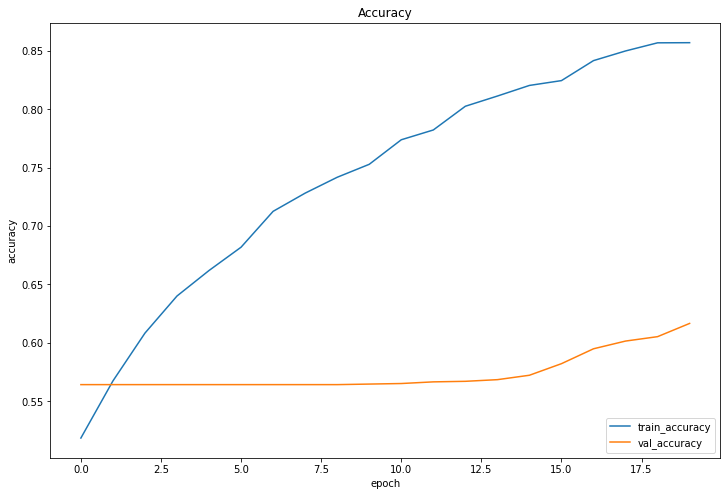

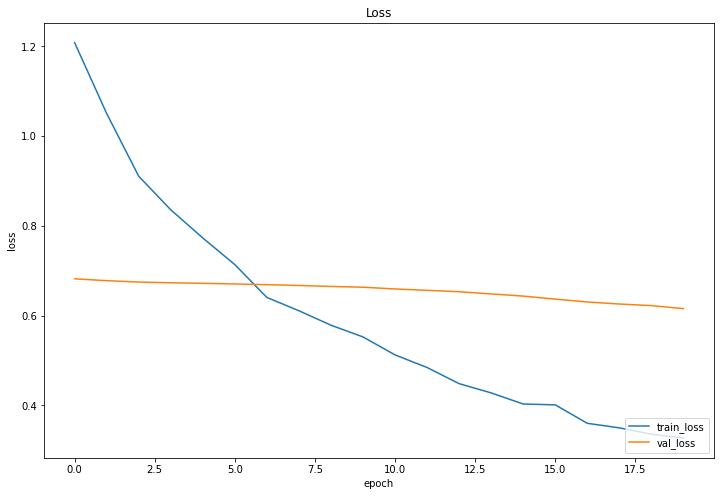

In [89]:
if __name__ == "__main__":
    vocab_size = 10000
    max_seq_length = 1000
    # 1. load your training data
    # expecting that the dat is already available , so commenting the function
    #download_data()
    print("downloaded data")

    # loading the train data and getting the data after pre-processing
    # creating data sets
    x_train, y_train, x_text, y_text = get_data_preprocessed(vocab_size, max_seq_length)
    print(x_train.shape)
    print("train data preprocessed 1")
    x_train, y_train = shuffle(x_train, y_train)
    print("train data preprocessed 2")

    # 2. Train your network
    # Make sure to print your training loss and accuracy within training to show progress
    history, model = run_model(x_train, y_train, 500, 1024, 512, 20, "./data/", 2, 10000, 1000)
    
       # print accuracy and loss graphs
    # Make sure you print the final training accuracy
    print("final training accuracy: ",history.history['accuracy'][-1])
    print("final training loss: ",history.history['loss'][-1])
    
    score = model.evaluate(x_text, y_text, batch_size=16)
    print("test_accuracy:", score)

    # print accuracy and loss graphs
    plot_graph_accuracy(history, "Accuracy")
    plot_graph_loss(history, "Loss")

    # 3. Save your model
    model.save("20841154_NLP_model.h5")